In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    os.mkdir(os.path.join(project_path, "tmp"))
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [5]:
lvlmin = 2
lvlmax = 120
gammas_vec = np.arange(0, 1.1, 0.1)
crossmod_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))
mod_sc_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))
mod_fc_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))
sim_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))

for idx, g in enumerate(gammas_vec):
    tree = json.loads(
        open(
            os.path.join(
                project_path,
                "data",
                "processed",
                "n" + str(conn_size),
                "tree_g_" + str(round(g, 2)) + ".json",
            )
        ).read()
    )
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin, lvlmax):
        level, labels = level_from_tree(tree, l)
        T = T_from_level(level)
        sim = np.nanmean(similarity_level(fcm_nonzero, scm_nonzero, level))
        mod_sc_lvl = modularity(scm_nonzero, T)
        mod_fc_lvl = modularity(fcm_nonzero, T)
        mod_sc.append(mod_sc_lvl)
        mod_fc.append(mod_fc_lvl)
        sim_lvl.append(sim)
        c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
        crossmod.append(c)
    crossmod_gammas[:, idx] = crossmod
    mod_sc_gammas[:, idx] = mod_sc
    mod_fc_gammas[:, idx] = mod_fc
    sim_gammas[:, idx] = sim_lvl


In [6]:
x, y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
opt_gamma = round(gammas_vec[y][0], 2)
opt_level = levels_vec[x][0]
key_pattern = "gamma_" + str(opt_gamma) + "_lvl_" + str(opt_level)
key_pattern

'gamma_0.7_lvl_28'

In [14]:
[all_yticks[i] for i in desired_yticks]

[2, 61, 119]

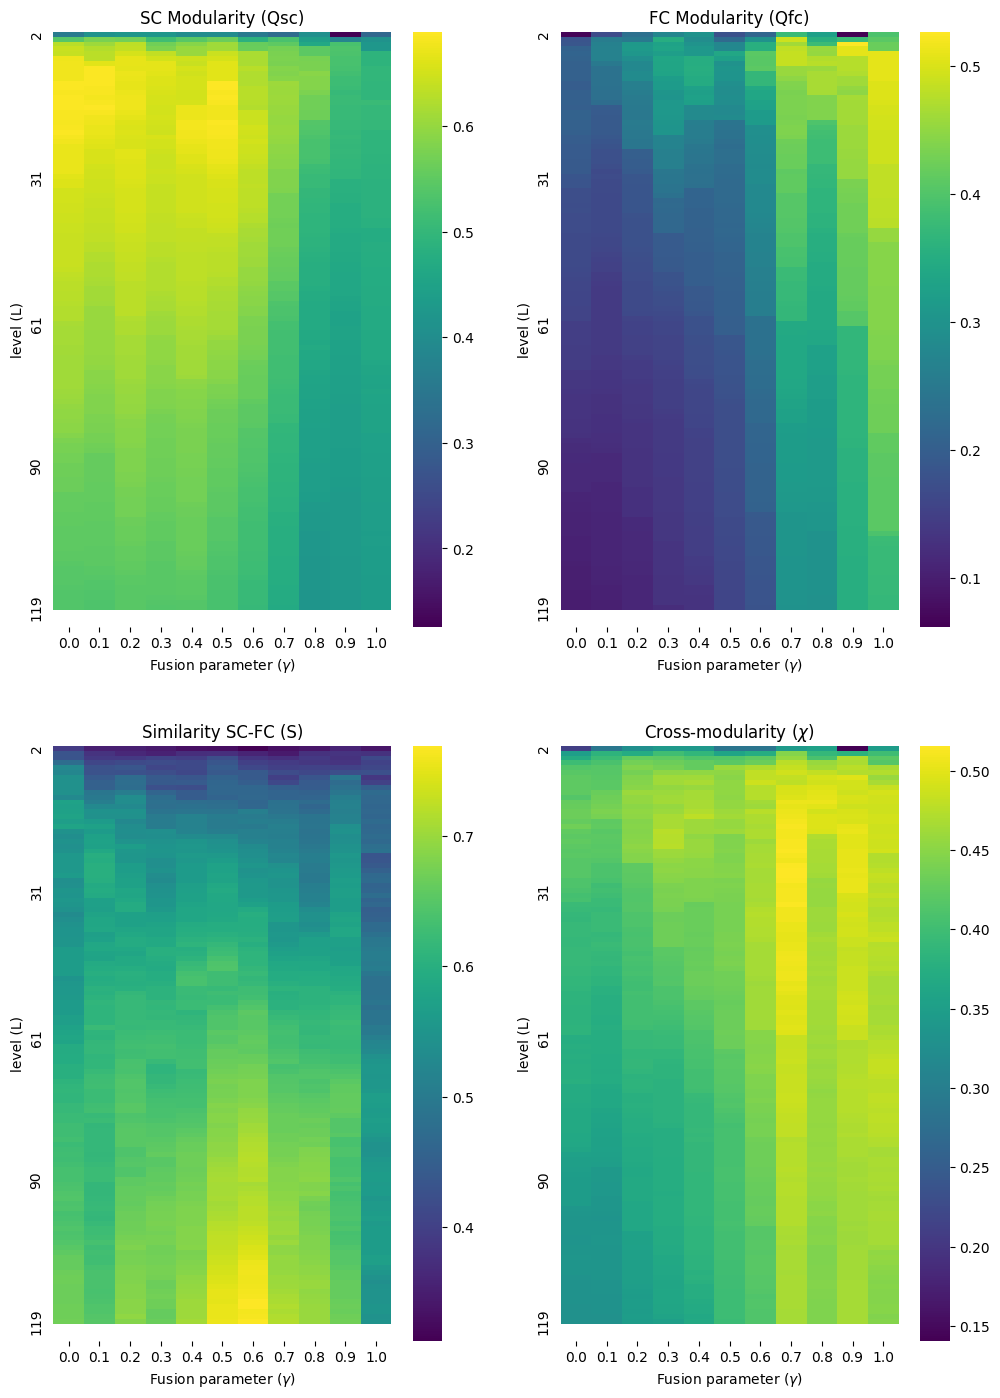

In [21]:
plot, axes = plt.subplots(2, 2, figsize=(12, 17))
all_yticks = np.arange(lvlmin, lvlmax)
desired_yticks = [0, len(all_yticks) // 4, len(all_yticks) // 2, 3*len(all_yticks) // 4, len(all_yticks) - 1]

h1 = sns.heatmap(
    mod_sc_gammas,
    cmap="viridis",
    xticklabels=np.around(np.arange(0, 1.1, 0.1), 2),
    yticklabels=[all_yticks[i] if i in desired_yticks else '' for i in range(len(all_yticks) + len(desired_yticks) - 1)],
    ax=axes[0, 0],
)
_ = h1.set(xlabel="Fusion parameter (" + r"$\gamma$" + ")", ylabel="level (L)")
_ = h1.set_title("SC Modularity (Qsc)")
_ = h1.tick_params(left=False)

h2 = sns.heatmap(
    mod_fc_gammas,
    cmap="viridis",
    xticklabels=np.around(np.arange(0, 1.1, 0.1), 2),
    yticklabels=[all_yticks[i] if i in desired_yticks else '' for i in range(len(all_yticks) + len(desired_yticks) - 1)],
    ax=axes[0, 1],
)
_ = h2.set(xlabel="Fusion parameter (" + r"$\gamma$" + ")", ylabel="level (L)")
_ = h2.set_title("FC Modularity (Qfc)")
_ = h2.tick_params(left=False)

h3 = sns.heatmap(
    sim_gammas,
    cmap="viridis",
    xticklabels=np.around(np.arange(0, 1.1, 0.1), 2),
    yticklabels=[all_yticks[i] if i in desired_yticks else '' for i in range(len(all_yticks) + len(desired_yticks) - 1)],
    ax=axes[1, 0],
)
_ = h3.set(xlabel="Fusion parameter (" + r"$\gamma$" + ")", ylabel="level (L)")
_ = h3.set_title("Similarity SC-FC (S)")
_ = h3.tick_params(left=False)

h4 = sns.heatmap(
    crossmod_gammas,
    cmap="viridis",
    xticklabels=np.around(np.arange(0, 1.1, 0.1), 2),
    yticklabels=[all_yticks[i] if i in desired_yticks else '' for i in range(len(all_yticks) + len(desired_yticks) - 1)],
    ax=axes[1, 1],
)
_ = h4.set(xlabel="Fusion parameter (" + r"$\gamma$" + ")", ylabel="level (L)")
_ = h4.set_title("Cross-modularity (" + r"$\chi$" +")")
_ = h4.tick_params(left=False)

plt.savefig(
    os.path.join(project_path, "data", "figures", "level_xmod.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

In [23]:
tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(conn_size),
            "tree_g_" + str(opt_gamma) + ".json",
        )
    ).read()
)
sm_thresh = 5
lvl = opt_level
level, labels = level_from_tree(tree, lvl)

initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

parcellation_moduled = np.zeros((initial_parcellation_data.shape[0], initial_parcellation_data.shape[1], initial_parcellation_data.shape[2]))

idx = 0
roi_size = []
for rois in level:
    if len(rois) > sm_thresh:
        roi_size.append(len(rois))
        mod = get_module_vol(initial_parcellation, rois, idx + 1)
        parcellation_moduled = parcellation_moduled + mod.astype(int)
        idx += 1
parcellation_img = nib.Nifti1Image(parcellation_moduled, affine=initial_parcellation.affine)
nib.save(
    parcellation_img,
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(conn_size),
        "optimal_parcellation.nii.gz",
    ),
)